### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


### 1. Feature importance признаков

In [180]:
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
import shap
shap.initjs()

df = pd.read_csv("bank-full.csv", delimiter=";") # https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['previous'] = df['previous'].map({'yes': 1, 'no': 0})
df['education'] = df['education'].map({'unknown': 0, 
                                       'primary': 1, 
                                       'secondary': 2, 
                                       'tertiary': 3})
df['marital'] = df['marital'].map({'single': 0, 
                                   'divorced': -1, 
                                   'married': 1})
df.fillna(0, inplace=True)
print(df.shape)
df.head(3)

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,1,3,0,2143,1,0,unknown,5,may,261,1,-1,0.0,unknown,0
1,44,technician,0,2,0,29,1,0,unknown,5,may,151,1,-1,0.0,unknown,0
2,33,entrepreneur,1,2,0,2,1,1,unknown,5,may,76,1,-1,0.0,unknown,0


В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [181]:
# features = ["age", "default", "balance", "housing", "loan", "duration", "campaign", "pdays", "previous", "education", "marital", "job", "contact", "month", "poutcome"]
features = ["age", "default", "balance", "housing", "loan", "duration", "campaign", "pdays", "previous", "education", "marital"]
target = "y"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

In [182]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    


final_transformers = list()
continuous_columns = ["age", "default", "balance", "housing", "loan", "duration", "campaign", "pdays", "previous", "education", "marital"]
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

# for cat_col in ["job", "contact", "month", "poutcome"]: # КАК ДОСТАТЬ  НАЗВАНИЯ КОЛОНОК ПОСЛЕ ONEHOT ИЗ ПАЙПЛАЙНА, ЕСЛИ get_feature_names_out() НЕ РАБОТАЕТ!?
#     cat_transformer = Pipeline([
#                 ('selector', ColumnSelector(key=cat_col)),
#                 ('ohe', OHEEncoder(key=cat_col))
#             ])
#     final_transformers.append((cat_col, cat_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

Модель - линейная регрессия

In [183]:
regressor = Pipeline([
    ('features', feats),
    ('classifier', LinearRegression()),
])

In [184]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('default',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='default')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('balance',
                                                 Pipeline(steps=[('selector',
                                         

In [185]:
predictions = regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.18053241746091353, 0.19120407638399384)

In [186]:
intercept = regressor[1].intercept_

features = pd.DataFrame(regressor[1].coef_,
                        continuous_columns,
                        columns=['coefficient'])
features.head()

,coefficient
age,0.001912
default,-0.003636
balance,0.009226
housing,-0.048823
loan,-0.016871


### Перейдем к "деревянным" моделям

In [187]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('default',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='default')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('balance',
                                                 Pipeline(steps=[('selector',
                                         

In [188]:
predictions = regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.14761321519156298, 0.2601140673058625)

In [189]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                            continuous_columns, 
                            columns=['coefficient'])
xgb_features.head()

,coefficient
age,0.061720
default,0.038153
balance,0.046332
housing,0.275290
loan,0.098370


### 2. Permutation importance

In [190]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regressor, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

In [193]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

duration 0.380 +/- 0.012
pdays 0.121 +/- 0.006
age 0.063 +/- 0.004
housing 0.049 +/- 0.005
campaign 0.009 +/- 0.002
balance 0.009 +/- 0.005
loan 0.006 +/- 0.002
marital 0.005 +/- 0.002
education 0.001 +/- 0.002
default 0.001 +/- 0.000
previous 0.000 +/- 0.000


### SHAP

In [205]:
model = xgb.train({"learning_rate": 0.01}, 
                  xgb.DMatrix(X_train, label=y_train),
                  100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


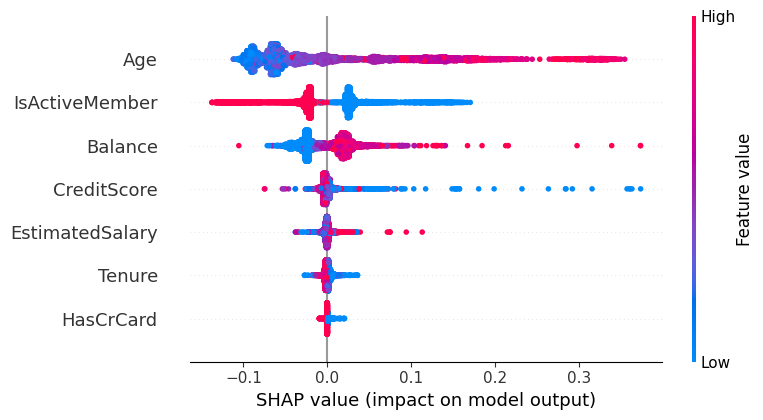

In [206]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

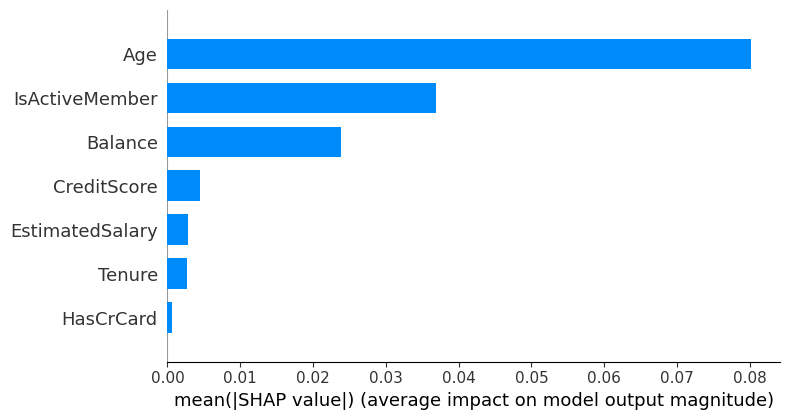

In [207]:
shap.summary_plot(shap_values, X_train, plot_type="bar")